# Finite State Machine (FSM) Sandbox

## Imports

In [1]:
import sys
import time
import matplotlib.pyplot as plt
import cv2
import math

import delivery_driver as dd

sys.path.append("../../deliveryrobot")
from utilities.utilities import *
from sensors.camera.apriltagsensor import *
from sensors.calibration.camera_calibration import *
from navigation.slam.onlineslam import *
from navigation.astar.astar import *
from kinematics.movementai import *
from utilities.computational_geometry import *

## Robot Initialization

In [2]:
# Robot Instance initialization
start_time = time.time()

robot = dd.DeliveryRobot()

print(f"Robot initialization complete in {time.time()-start_time} seconds")

# Apriltag Sensor initialization
start_time = time.time()

sensor = AprilTagSensor(cal_dir)

print(f"Sensor calibration and initialization in {time.time()-start_time} seconds")

april_live = "live_april"

# SLAM Instance initialization
start_time = time.time()

slam = OnlineSLAM(3)
slam.debug = False

print(f"SLAM initialization in {time.time()-start_time} seconds")

# Astar Instance initialization
start_time = time.time()

scalar = 1
astar = Astar(
    beam_resolution=5,
    beam_range=np.pi/4,
    max_distance=0.2*scalar,
    heuristic_weight=1000/scalar,
    cost=1,
    fos=1,
    robot_radius_m=0.015*scalar
)
astar.debug = False
astar.verbose = False

print(f"Astar initialization in {time.time()-start_time} seconds")

Robot initialization complete in 0.9101922512054443 seconds
AprilTag sensor setup COMPLETE
Sensor calibration and initialization in 0.007624387741088867 seconds
SLAM initialization in 0.0008406639099121094 seconds
Astar initialization in 0.0010275840759277344 seconds


## Map Initialization

In [3]:
# sensor measurement
start_time = time.time()

april_img = robot.take_picture(image_dir + "/testing/pose_test/")
measurements={}
obstacles = {}
sensor.detect(april_img, measurements)

print(f"Sensor detections in {time.time()-start_time} seconds")
print(measurements)

# SLAM measurement
start_time = time.time()

slam.set_world_frame(int(list(measurements.keys()).index("1")))
slam.initialize_filters({"psi":measurements["1"][2]})
slam.process_measurements(measurements)
slam.map_update(False)

print(f"SLAM estimation in {time.time()-start_time} seconds")
print(slam.get_map())

Sensor detections in 0.20399212837219238 seconds
{'1': [1.9404923146587871, -0.19795463850644004, 0.20373321517823606]}
World frame set to 1
SLAM estimation in 0.033865928649902344 seconds
{'ROBOT': array([-1.94049231,  0.19795464, -0.20373322]), '1': array([0., 0., 0.])}


## Robot Calibration
Calibrate kalman filter and build some SLAM estimates

In [4]:
"""execute_time = 1
call_time = 0

# get cumulative dead reckoning to contribute to SLAM
x_cum = 0.
y_cum = 0.
psi_cum = 0.

# setup current and first target
robot_state = np.array(slam.get_map()["ROBOT"])
robot.robot_ai.slam_update([0.0,0.0,0.0])
robot.target_ai.slam_update([0.25,0.0,0.0])
"""

'execute_time = 1\ncall_time = 0\n\n# get cumulative dead reckoning to contribute to SLAM\nx_cum = 0.\ny_cum = 0.\npsi_cum = 0.\n\n# setup current and first target\nrobot_state = np.array(slam.get_map()["ROBOT"])\nrobot.robot_ai.slam_update([0.0,0.0,0.0])\nrobot.target_ai.slam_update([0.25,0.0,0.0])\n'

In [5]:
"""# step forward so rotation available (if on wall)
res = robot.arrive_ai(execute_time, call_time)
start_time = time.time()
last_call = time.time()
total_time = 0

while res[0]:
    
    # get time it took to make the call
    last_call = time.time()
    call_time = last_call - start_time
    total_time += call_time
    
    # set a new start time
    start_time = time.time()
    
    if total_time > 4:
        robot.robot.stop()
        break
        
    res = robot.arrive_ai(execute_time, call_time)
    
    # get cumulative values
    x_cum += res[1]
    y_cum += res[2]
    psi_cum += res[3]
    
robot.robot.stop()"""

'# step forward so rotation available (if on wall)\nres = robot.arrive_ai(execute_time, call_time)\nstart_time = time.time()\nlast_call = time.time()\ntotal_time = 0\n\nwhile res[0]:\n    \n    # get time it took to make the call\n    last_call = time.time()\n    call_time = last_call - start_time\n    total_time += call_time\n    \n    # set a new start time\n    start_time = time.time()\n    \n    if total_time > 4:\n        robot.robot.stop()\n        break\n        \n    res = robot.arrive_ai(execute_time, call_time)\n    \n    # get cumulative values\n    x_cum += res[1]\n    y_cum += res[2]\n    psi_cum += res[3]\n    \nrobot.robot.stop()'

In [6]:
"""# sensor measurement
april_img = robot.take_picture(image_dir + "/testing/pose_test/")
measurements={}
sensor.detect(april_img, measurements)

# slam update
if measurements: slam.process_measurements(measurements)
translation_m = math.sqrt(x_cum ** 2 + y_cum ** 2)
slam.process_movement(translation_m, psi_cum)
slam.map_update(True)
"""

'# sensor measurement\napril_img = robot.take_picture(image_dir + "/testing/pose_test/")\nmeasurements={}\nsensor.detect(april_img, measurements)\n\n# slam update\nif measurements: slam.process_measurements(measurements)\ntranslation_m = math.sqrt(x_cum ** 2 + y_cum ** 2)\nslam.process_movement(translation_m, psi_cum)\nslam.map_update(True)\n'

In [7]:
"""robot.step_left(0.15,0.4) # np.pi/8

april_img = robot.take_picture(image_dir + "/testing/pose_test/")
measurements={}
sensor.detect(april_img, measurements)

if measurements: slam.process_measurements(measurements)
slam.process_movement(0.0, np.pi/4)
slam.map_update(True)

time.sleep(0.5)

for i in range(4):
    robot.step_right(0.15,0.2) # np.pi/8
    
    april_img = robot.take_picture(image_dir + "/testing/pose_test/")
    measurements={}
    sensor.detect(april_img, measurements)
    
    if measurements: slam.process_measurements(measurements)
    slam.process_movement(0.0, -np.pi/8)
    slam.map_update(True)

    time.sleep(0.5)
    
robot.step_left(0.15,0.4)

april_img = robot.take_picture(image_dir + "/testing/pose_test/")
measurements={}
sensor.detect(april_img, measurements)

if measurements: slam.process_measurements(measurements)
slam.process_movement(0.0, np.pi/4)
slam.map_update(True)
"""

'robot.step_left(0.15,0.4) # np.pi/8\n\napril_img = robot.take_picture(image_dir + "/testing/pose_test/")\nmeasurements={}\nsensor.detect(april_img, measurements)\n\nif measurements: slam.process_measurements(measurements)\nslam.process_movement(0.0, np.pi/4)\nslam.map_update(True)\n\ntime.sleep(0.5)\n\nfor i in range(4):\n    robot.step_right(0.15,0.2) # np.pi/8\n    \n    april_img = robot.take_picture(image_dir + "/testing/pose_test/")\n    measurements={}\n    sensor.detect(april_img, measurements)\n    \n    if measurements: slam.process_measurements(measurements)\n    slam.process_movement(0.0, -np.pi/8)\n    slam.map_update(True)\n\n    time.sleep(0.5)\n    \nrobot.step_left(0.15,0.4)\n\napril_img = robot.take_picture(image_dir + "/testing/pose_test/")\nmeasurements={}\nsensor.detect(april_img, measurements)\n\nif measurements: slam.process_measurements(measurements)\nslam.process_movement(0.0, np.pi/4)\nslam.map_update(True)\n'

In [8]:
slam.get_map()["1"]

array([0., 0., 0.])

In [9]:
robot.stop()

## Path Initialization

In [10]:
# Astar Path Planning
goal_id = "1"
print("ROBOT STATE", slam.get_map()["ROBOT"])
print("GOAL STATE", slam.get_map()[goal_id])
robot_state = slam.get_map()["ROBOT"]
goal_state = slam.get_map()[goal_id]
goal_state[0] -= 0.4

start_time = time.time()

astar_test = astar.astar_move(robot_state, obstacles, goal_state)

print(f"Astar path planning in {time.time() - start_time} seconds; Results are:")
astar_test.print_info()

ROBOT STATE [-1.94049231  0.19795464 -0.20373322]
GOAL STATE [0. 0. 0.]
[-1.94049231  0.19795464 -0.20373322]
[-1.7446287   0.15748929 -0.20373322]
01:51:59 - - - - - - UPCOMING PATH:
 - - - - - - - - - - - - - - -

	NODE: 0
                                    	LOC: [-1.94049231  0.19795464 -0.20373322]

	NODE: 6
                                    	LOC: [-1.7446287   0.15748929 -0.20373322]

	NODE: 18
                                    	LOC: [-1.54484632  0.14816196 -0.04665358]

	NODE: 27
                                    	LOC: [-1.3489827   0.10769661 -0.20373322]

	NODE: 40
                                    	LOC: [-1.14920032  0.09836928 -0.04665358]

	NODE: 49
                                    	LOC: [-0.9533367   0.05790393 -0.20373322]

	NODE: 62
                                    	LOC: [-0.75355432  0.0485766  -0.04665358]

	NODE: 70
                                    	LOC: [-0.56643228 -0.02203037 -0.36081285]

Astar path planning in 0.11942148208618164 seconds; Result

## Re-orient to first path direction

In [11]:
print(astar_test.path)
print(relative_angle(astar_test.path[0][1],astar_test.path[1][1]))
relative_angle_rad = relative_angle(astar_test.path[0][1],astar_test.path[1][1])
robot.robot_ai.slam_update([0.0,0.0,0.0])
robot.target_ai.slam_update([0.0,0.0,relative_angle_rad])

goal_time = 1
start_time = time.time()
last_call = time.time()
call_time = 0
i = 0
total_time = 0
res = robot.align_ai(goal_time, call_time)
while res[0]:
    
    # get time it took to make the call
    last_call = time.time()
    call_time = last_call - start_time
    total_time+=call_time
    
    # set a new start time
    start_time = time.time()

    #time.sleep(0.2)
    
    i+=1
    if total_time > 4:
        robot.robot.stop()
        break
        
    res = robot.align_ai(goal_time, call_time)
    
april_img = robot.take_picture(image_dir + "/testing/pose_test/")
measurements={}
sensor.detect(april_img, measurements)

if measurements: slam.process_measurements(measurements)
slam.process_movement(0.0, relative_angle_rad)
slam.map_update(True)
        
robot.robot.stop()

[(0, array([-1.94049231,  0.19795464, -0.20373322])), (6, array([-1.7446287 ,  0.15748929, -0.20373322])), (18, array([-1.54484632,  0.14816196, -0.04665358])), (27, array([-1.3489827 ,  0.10769661, -0.20373322])), (40, array([-1.14920032,  0.09836928, -0.04665358])), (49, array([-0.9533367 ,  0.05790393, -0.20373322])), (62, array([-0.75355432,  0.0485766 , -0.04665358])), (70, array([-0.56643228, -0.02203037, -0.36081285]))]
-0.20373321517823584
ALIGNED


## Movement Initialization and Prepare Plotter

In [12]:
goal_time = 1
call_time = 0
total_time = 0
start_time = time.time()
last_call = time.time()
n = -1
t = 0
thresh = 2

x_dr = []
y_dr = []
psi_dr = []
x_meas = []
y_meas = []
psi_meas = []
x_slam = []
y_slam = []
psi_slam = []
sensor_run = []

translation_m_sum = 0
delta_theta_sum = 0

x_dr_t, y_dr_t, psi_dr_t = robot_state

# update from slam
robot.slam_update_ai(robot_state, goal_state)

# setup path and target
robot.update_path_ai(astar_test.path)

# Path Follow State

In [13]:
import matplotlib.pyplot as plt

def plot_estimations(x_dead_reckoning, y_dead_reckoning, psi_dead_reckoning,
                     x_slam, y_slam, psi_slam, 
                     x_meas=None, y_meas=None, psi_meas=None, 
                     time=None, bars=None):
    """
    Plots the x, y, and psi (orientation) estimations for dead reckoning, SLAM + sensors, and measurements,
    with optional vertical bars.

    Parameters:
    x_dead_reckoning (list or np.ndarray): X positions from dead reckoning.
    y_dead_reckoning (list or np.ndarray): Y positions from dead reckoning.
    psi_dead_reckoning (list or np.ndarray): Psi (orientation) from dead reckoning.
    x_slam (list or np.ndarray): X positions from SLAM + sensors.
    y_slam (list or np.ndarray): Y positions from SLAM + sensors.
    psi_slam (list or np.ndarray): Psi (orientation) from SLAM + sensors.
    x_meas (list or np.ndarray, optional): X positions from measurements.
    y_meas (list or np.ndarray, optional): Y positions from measurements.
    psi_meas (list or np.ndarray, optional): Psi (orientation) from measurements.
    time (list or np.ndarray, optional): Time or sample indices. Defaults to indices of the arrays.
    bars (list or np.ndarray, optional): Binary array where 1s indicate positions to add vertical bars.

    Returns:
    None: The function directly shows the plots.
    """
    if time is None:
        time = range(len(x_dead_reckoning))  # Use index range if time is not provided
    
    if bars is None:
        bars = [0] * len(time)  # Default to no bars if not provided
    
    # Create the subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Plot x
    axs[0].plot(time, x_dead_reckoning, label='Dead Reckoning', marker='o')
    axs[0].plot(time, x_slam, label='SLAM + Sensors', marker='x')
    if x_meas is not None:
        axs[0].plot(time, x_meas, label='Measurements', marker='s', linestyle=':')
    axs[0].set_title('X Position Comparison')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('X Position')
    axs[0].legend()

    # Plot y
    axs[1].plot(time, y_dead_reckoning, label='Dead Reckoning', marker='o')
    axs[1].plot(time, y_slam, label='SLAM + Sensors', marker='x')
    if y_meas is not None:
        axs[1].plot(time, y_meas, label='Measurements', marker='s', linestyle=':')
    axs[1].set_title('Y Position Comparison')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Y Position')
    axs[1].legend()

    # Plot psi (orientation)
    axs[2].plot(time, psi_dead_reckoning, label='Dead Reckoning', marker='o')
    axs[2].plot(time, psi_slam, label='SLAM + Sensors', marker='x')
    if psi_meas is not None:
        axs[2].plot(time, psi_meas, label='Measurements', marker='s', linestyle=':')
    axs[2].set_title('Psi (Orientation) Comparison')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Psi (Orientation)')
    axs[2].legend()

    # Add vertical bars
    for i, t in enumerate(time):
        if bars[i] == 1:
            axs[0].axvline(x=t, color='red', linestyle='--', linewidth=1)
            axs[1].axvline(x=t, color='red', linestyle='--', linewidth=1)
            axs[2].axvline(x=t, color='red', linestyle='--', linewidth=1)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

IDX No 2 STATES LEN 8

------------ TIME STEP 0 -------------

translation_m = 0.0 | delta_theta = -0.0
IDX No 2 STATES LEN 8

Path Follow Time: 0.04044032096862793
Robot State = [-1.92568492  0.19529555]
Goal State = [-1.54484632  0.14816196]
SLAM Map: {'ROBOT': array([-1.92568492,  0.19529555, -0.33914439]), '1': array([0., 0., 0.]), '0': array([1.27614489, 2.25359736, 0.13285441])}


------------ TIME STEP 1 -------------

translation_m = 1.7327348890509624e-05 | delta_theta = 0.0
IDX No 2 STATES LEN 8

Path Follow Time: 0.04715299606323242
Robot State = [-1.92561513  0.19527093]
Goal State = [-1.54484632  0.14816196]
SLAM Map: {'ROBOT': array([-1.92561513,  0.19527093, -0.33914439]), '1': array([0., 0., 0.]), '0': array([1.27614489, 2.25359736, 0.13285441])}


------------ TIME STEP 2 -------------

translation_m = 5.482144630964961e-05 | delta_theta = 0.0002761987539438101
IDX No 2 STATES LEN 8

Path Follow Time: 0.05635213851928711
Robot State = [-1.92531064  0.19516393]
Goal Sta

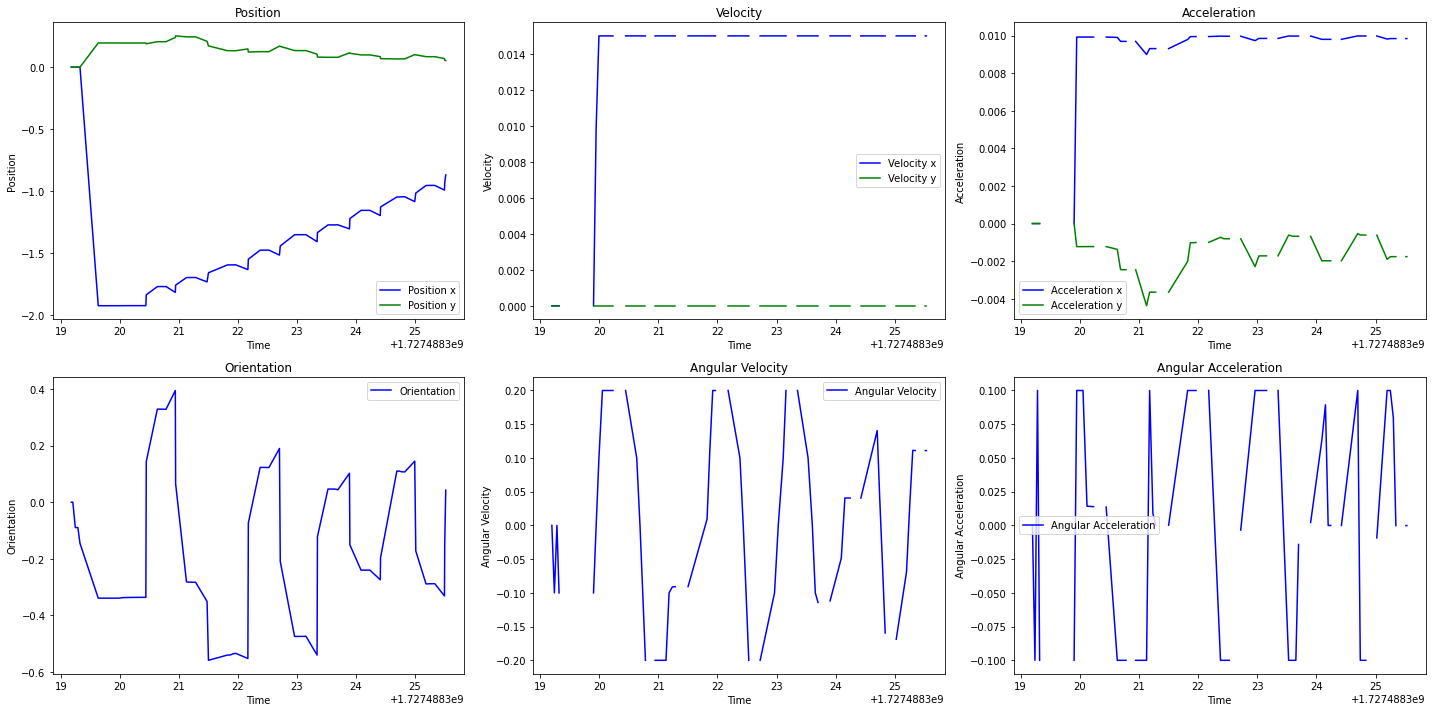

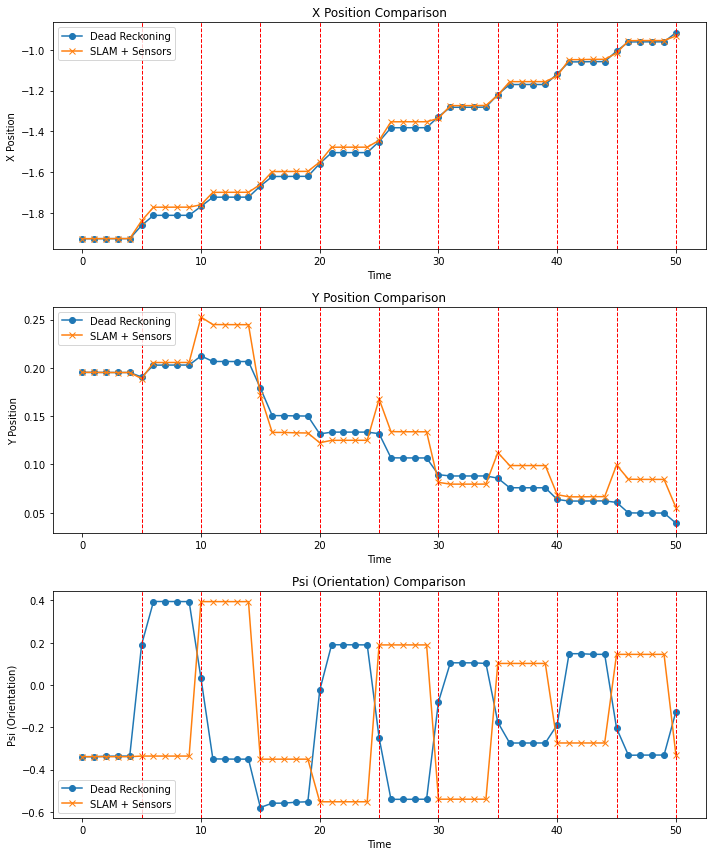

In [14]:


# false if within parking range
output, delta_x, delta_y, delta_theta = robot.path_follow_ai(goal_time, call_time)

while output:
    
    print(f"\n------------ TIME STEP {t} -------------\n")
    
    # set a new start time
    start_time = time.time()
    
    # determine translation magnitude
    translation_m = math.sqrt(delta_x ** 2 + delta_y ** 2)
    translation_m_sum += translation_m
    delta_theta_sum += delta_theta
    print(f"translation_m = {translation_m} | delta_theta = {delta_theta}")
    
    if n == 4: sensor_run.append(1)
    else: sensor_run.append(0)
    
    if n == 4:
        
        # AprilSensor
        sensor_time = time.time()
        april_img = robot.take_picture(image_dir + "/testing/pose_test/")
        measurements = {}
        sensor.detect(april_img, measurements)
        
        print()
        print(f"AprilSensor in {time.time() - sensor_time} seconds")
        print(f"Sensor Measurements: {measurements}")
        print()
        
        # SLAM measurement update
        slam_time = time.time()
        if not measurements: slam.process_measurements(measurements)
        slam.process_movement(translation_m_sum, delta_theta_sum)
        slam.map_update(motion=True)
        
        # update movement ai objects
        robot_state = slam.get_map()["ROBOT"]
        goal_state = slam.get_map()["1"]
        robot.slam_update_ai(robot_state, goal_state)
        
        translation_m_sum = 0
        delta_theta_sum = 0
        
        print()
        print(f"SLAM Full Update in {time.time() - slam_time} seconds")
        print()
            
    elif n == 5:
        
        # Astar map update
        astar_time = time.time()
        print("CURRENT ROBOT STATE:",robot_state)
        print("SLAM ROBOT STATE:",slam.get_map()["ROBOT"])
        robot_state = slam.get_map()["ROBOT"]
        goal_state = slam.get_map()[goal_id]
        goal_state[0] -= 0.4
        print("GOALSTATE BABY",robot_state, obstacles, goal_state)
        astar_test = astar.astar_move(robot_state, obstacles, goal_state)
        #robot.update_path_ai(astar_test.path)
        
        print()
        print(f"Astar in {time.time() - astar_time} seconds")
        print()
        
        n = 0
    
    # check if stalling
    if total_time > 4:
        robot.robot.stop()
        break
    
    # get time since last call
    call_time = time.time() - start_time
    total_time += call_time
    
    pf_time = time.time()
    output, delta_x, delta_y, delta_theta = robot.path_follow_ai(goal_time, call_time)
    
    print()
    print(f"Path Follow Time: {time.time() - pf_time}")
    print(f"Robot State = {robot.robot_ai.position}")
    print(f"Goal State = {robot.target_ai.position}")
    print(f"SLAM Map: {slam.get_map()}")
    print()
    
    # update arrays
    x_dr_t += delta_x
    y_dr_t += delta_y
    psi_dr_t += delta_theta
    x_slam_t, y_slam_t, psi_slam_t = slam.get_map()["ROBOT"]
    
    x_dr.append(x_dr_t)
    y_dr.append(y_dr_t)
    psi_dr.append(psi_dr_t)
    x_slam.append(x_slam_t)
    y_slam.append(y_slam_t)
    psi_slam.append(psi_slam_t)
    
    if "1" in measurements:
        x_meas_t, y_meas_t, psi_meas_t = measurements["1"]
        x_meas.append(x_meas_t)
        y_meas.append(y_meas_t)
        psi_meas.append(psi_meas_t)
    
    n += 1
    t += 1

arrive_time = 0
    
while robot.arrive_ai(goal_time, call_time):
    
    # set a new start time
    start_time = time.time()
    
    if t > 25:
        robot.robot.stop()
        break
        
    t += 1
    
    # get time since last call
    call_time = time.time() - start_time
    total_time += call_time

robot.robot.stop()
robot.robot_ai.kplot.plot_data()
plot_estimations(x_dr, y_dr, psi_dr, x_slam, y_slam, psi_slam, time=None, bars=sensor_run)

In [15]:
robot.stop()

In [16]:
"""robot.update_path_ai(astar_test.path)

# setup time variables
goal_time = 1
call_time = 0
total_time = 0
start_time = time.time()
last_call = time.time()
n = 0
m = 0
thresh = 2

while robot.path_follow_ai(goal_time, call_time):
    
    # get time it took to make the call
    last_call = time.time()
    call_time = last_call - start_time
    total_time+=call_time
    
    # set a new start time
    start_time = time.time()
    
    if n > 5:
        if m > thresh:
            time.sleep(0.45)
            print("long pause")
            m = 0
            thresh += 1
        print("pause")
        time.sleep(0.25)
        n = 0
        m += 1
    else:
        n += 1
    
    
    if total_time > 4:
        robot.robot.stop()
        
        break

robot.target_ai.slam_update(goal_state)
print(f"targeting {goal_state} from {robot.robot_ai.position}")

while robot.arrive_ai(goal_time, call_time):
    
    # get time it took to make the call
    last_call = time.time()
    call_time = last_call - start_time
    total_time+=call_time
    
    # set a new start time
    start_time = time.time()
    
    if total_time > 4:
        robot.robot.stop()
        break

robot.robot.stop()
robot.robot_ai.kplot.plot_data()"""

'robot.update_path_ai(astar_test.path)\n\n# setup time variables\ngoal_time = 1\ncall_time = 0\ntotal_time = 0\nstart_time = time.time()\nlast_call = time.time()\nn = 0\nm = 0\nthresh = 2\n\nwhile robot.path_follow_ai(goal_time, call_time):\n    \n    # get time it took to make the call\n    last_call = time.time()\n    call_time = last_call - start_time\n    total_time+=call_time\n    \n    # set a new start time\n    start_time = time.time()\n    \n    if n > 5:\n        if m > thresh:\n            time.sleep(0.45)\n            print("long pause")\n            m = 0\n            thresh += 1\n        print("pause")\n        time.sleep(0.25)\n        n = 0\n        m += 1\n    else:\n        n += 1\n    \n    \n    if total_time > 4:\n        robot.robot.stop()\n        \n        break\n\nrobot.target_ai.slam_update(goal_state)\nprint(f"targeting {goal_state} from {robot.robot_ai.position}")\n\nwhile robot.arrive_ai(goal_time, call_time):\n    \n    # get time it took to make the call\

###### 